In [1]:

#imports
from csv import reader
from random import seed
from random import randrange
from math import sqrt
from math import exp
from math import pi
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from fractions import Fraction
from io import StringIO
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt



In [2]:
# Read the CSV file
movieReviews = pd.read_csv('cleaned_reviews.csv', sep=',', header=None, names=['review_score', 'review_content'])

#get rid of scores of 0
movieReviews = movieReviews[movieReviews['review_score'] != 0]
# Remove rows with non-numeric review scores
movieReviews = movieReviews[~movieReviews['review_score'].str.contains('\.')]

# Keep only rows where review_score ends with '/5'
movieReviews = movieReviews[movieReviews['review_score'].str.endswith('/5')]

# Reset the index
movieReviews = movieReviews.reset_index(drop=True)

# Display information about the DataFrame
print("Null values in review_content:", movieReviews['review_content'].isnull().sum())
print("Shape of the DataFrame:", movieReviews.shape)

# Display the first few rows of the DataFrame
movieReviews.head()

movie_titles = pd.read_csv('movie_titles.csv')['movie_title'].tolist()



Null values in review_content: 0
Shape of the DataFrame: (50937, 2)


In [3]:
#Display information about the DataFrame
print("Null values in review_content:", movieReviews['review_content'].isnull().sum())
print("Shape of the DataFrame:", movieReviews.shape)

# Read movie titles
movie_titles = pd.read_csv('movie_titles.csv')['movie_title'].tolist()

# Iterate through each movie title and remove it from review_content
#for title in movie_titles:
    #movieReviews['review_content'] = movieReviews['review_content'].str.replace(re.escape(title), '')

# Display the first few rows of the DataFrame
#movieReviews.head()

Null values in review_content: 0
Shape of the DataFrame: (50937, 2)


In [4]:
stopwords_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
    "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
    'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'film', 'movie', 'still'
]

# Tokenize and remove stopwords
movieReviews['review_content'] = movieReviews['review_content'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.isalpha() and word.lower() not in stopwords_list]))

# Display the modified DataFrame
print(movieReviews.head())

  review_score                                     review_content
0          3/5  crammed dragons fights things exploding columb...
1          2/5  chris columbus returns comfort zone mirthless ...
2          2/5  although standard allegorical bases movies dut...
3          3/5  even familiar first book rick riordan popular ...
4          2/5  generic filmmaking banal simplification overwh...


In [5]:
# turn fractions into percentages

# Convert decimal strings to fractions
movieReviews['review_score'] = movieReviews['review_score'].apply(lambda x: Fraction(x))

# Convert fractions to percentages
movieReviews['review_score_percentage'] = movieReviews['review_score'] * 100

movieReviews.head()

,review_score,review_content,review_score_percentage
0,3/5,crammed dragons fights things exploding columb...,60
1,2/5,chris columbus returns comfort zone mirthless ...,40
2,2/5,although standard allegorical bases movies dut...,40
3,3/5,even familiar first book rick riordan popular ...,60
4,2/5,generic filmmaking banal simplification overwh...,40


In [6]:
# Define bins and labels
bins = [0, 19, 39, 59, 79, 100]
labels = [1, 2, 3, 4, 5]

# Create a new column 'review_label' based on the specified ranges
movieReviews['review_label'] = pd.cut(movieReviews['review_score_percentage'], bins=bins, labels=labels, include_lowest=True)


movieReviews.head()

,review_score,review_content,review_score_percentage,review_label
0,3/5,crammed dragons fights things exploding columb...,60,4
1,2/5,chris columbus returns comfort zone mirthless ...,40,3
2,2/5,although standard allegorical bases movies dut...,40,3
3,3/5,even familiar first book rick riordan popular ...,60,4
4,2/5,generic filmmaking banal simplification overwh...,40,3


In [7]:
def calculate_average_length(df, score):
    # Exclude reviews with score 0
    reviews = df[(df['review_score'] == score) & (df['review_score'] != 0)]['review_content']
    if reviews.empty:
        return 0  # Return 0 if no reviews with the specified score are found
    average_length = reviews.apply(len).mean()
    return average_length

# Print average length for each review score
for score in movieReviews['review_score'].unique():
    avg_length = calculate_average_length(movieReviews, score)
    print(f'Average length of reviews with score {score}: {avg_length:.2f} characters')

Average length of reviews with score 3/5: 82.89 characters
Average length of reviews with score 2/5: 80.00 characters
Average length of reviews with score 1/5: 77.03 characters
Average length of reviews with score 4/5: 83.72 characters
Average length of reviews with score 1: 80.70 characters
Average length of reviews with score 0: 0.00 characters


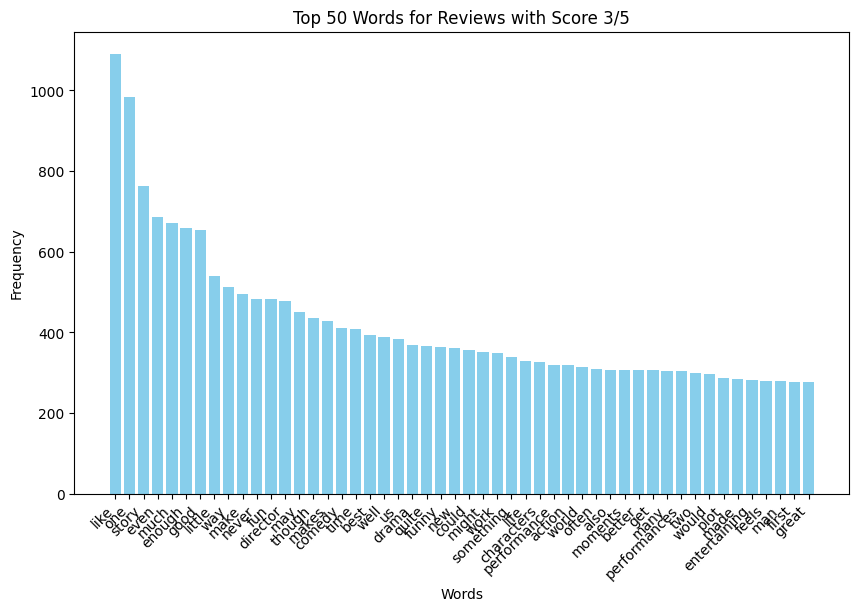

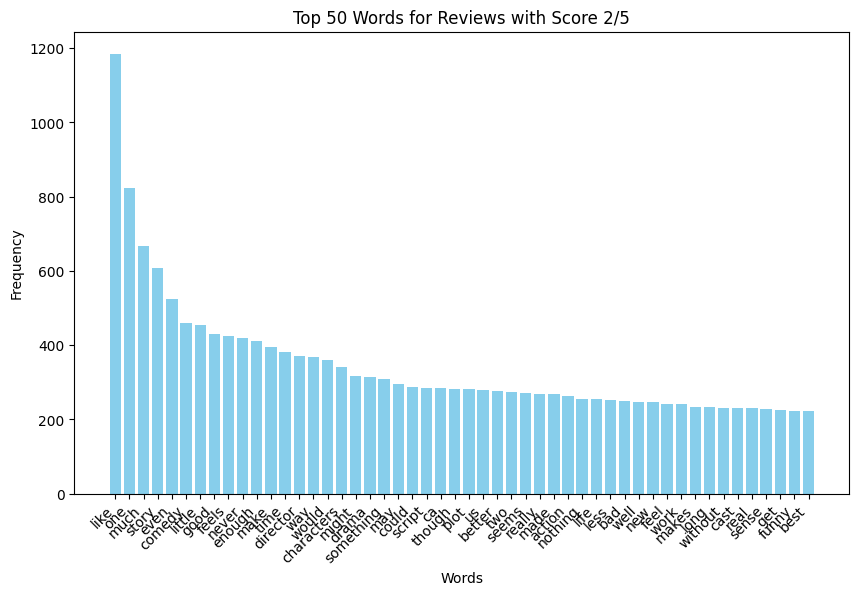

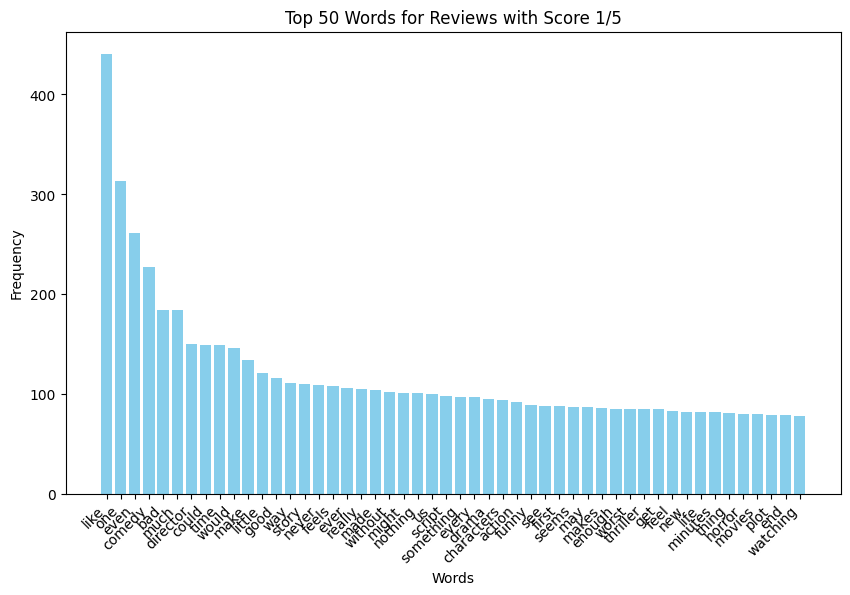

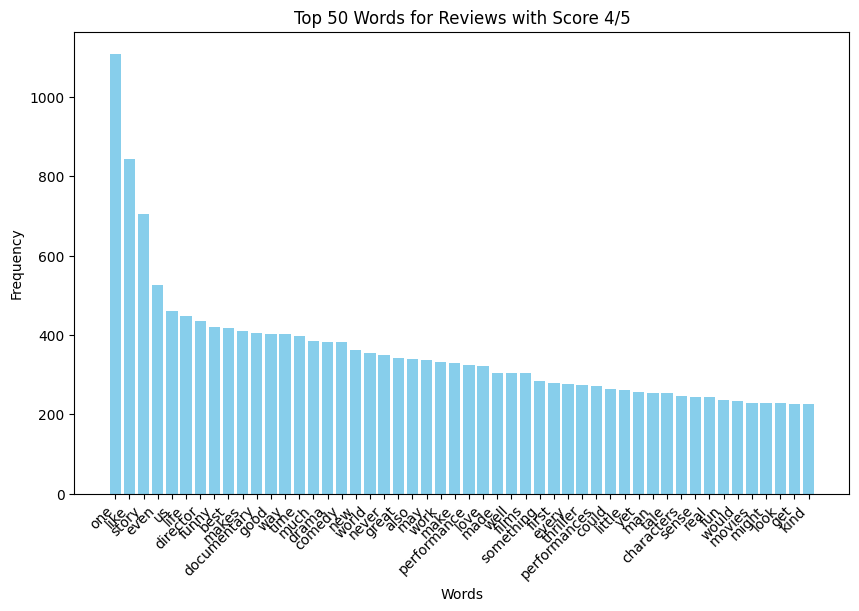

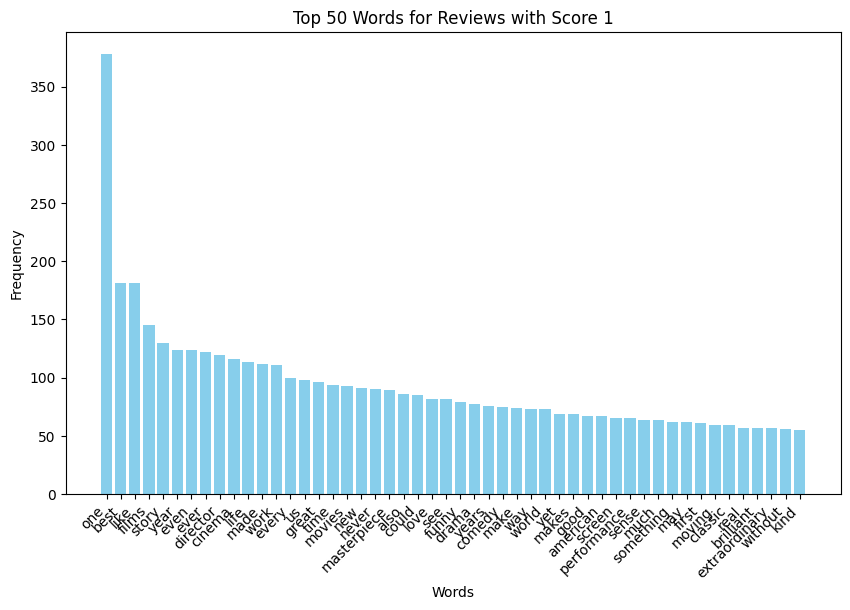

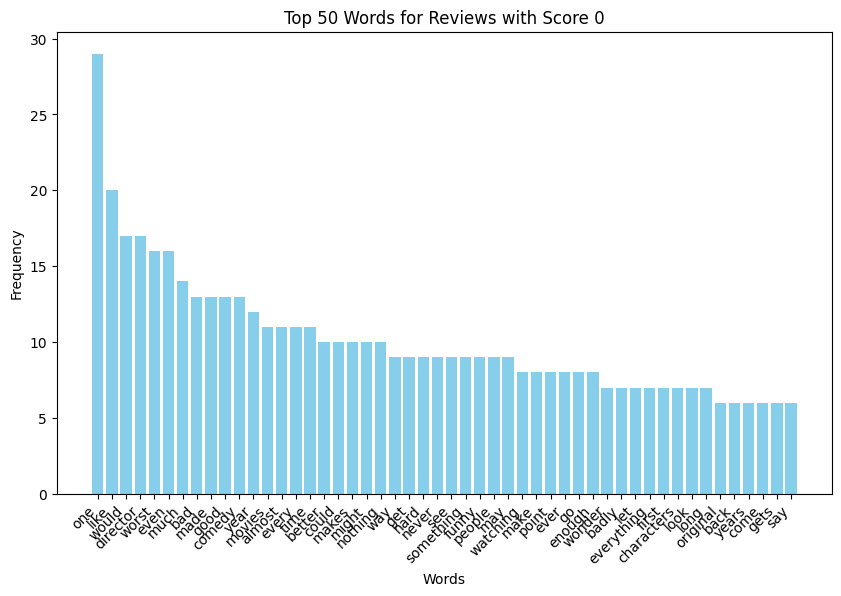

In [8]:
def get_top_words_by_score(df, score, top_n=50):
    score_reviews = df[df['review_score'] == score]['review_content'].str.lower().str.cat(sep=' ')
    
    # Tokenize words
    words = word_tokenize(score_reviews)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    
    # Get the top N words
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(top_n)
    
    return top_words

# Visualize top words for each review score
for score in movieReviews['review_score'].unique():
    top_words = get_top_words_by_score(movieReviews, score)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(*zip(*top_words), color='skyblue')
    plt.title(f'Top 50 Words for Reviews with Score {score}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [9]:
#finding the top 50 words for each rating

# Function to preprocess text (tokenization, lowercase, and removing stopwords)
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return words

train_data, test_data = train_test_split(movieReviews, test_size=0.1, random_state=42)

# Get rid of punctuation and convert text to lowercase
def preprocess_text(text):
    text = text.str.replace('\W', ' ')  # Removes punctuation
    text = text.str.lower()  # Converts text to lowercase
    return text

train_data['review_content'] = preprocess_text(train_data['review_content'])
test_data['review_content'] = preprocess_text(test_data['review_content'])

# Tokenize and build vocabulary
all_words = ' '.join(train_data['review_content'])
all_words = word_tokenize(all_words)
vocabulary = set(all_words)


In [10]:
movieReviews.head()

,review_score,review_content,review_score_percentage,review_label
0,3/5,crammed dragons fights things exploding columb...,60,4
1,2/5,chris columbus returns comfort zone mirthless ...,40,3
2,2/5,although standard allegorical bases movies dut...,40,3
3,3/5,even familiar first book rick riordan popular ...,60,4
4,2/5,generic filmmaking banal simplification overwh...,40,3


In [38]:
from collections import Counter
#Naive Bayes implementation

# Naive Bayes parameters
alpha = .085

# Initiate parameters
parameters_per_rating = {rating: Counter() for rating in range(1, 6)}

# Calculate parameters
for rating in range(1, 6):
    rating_data = train_data[train_data['review_label'] == rating]['review_content']
    n_rating = len(rating_data)
    
    # Count occurrences of each word in the entire column
    word_counts = Counter(' '.join(rating_data).split())
    
    for word in vocabulary:
        n_word_given_rating = word_counts[word]
        p_word_given_rating = (n_word_given_rating + alpha) / (n_rating + alpha * len(vocabulary))
        parameters_per_rating[rating][word] = p_word_given_rating

In [39]:
#classifier 
# Naive Bayes classifier
def predict_rating(review, parameters, n_rating):
    words = word_tokenize(review)
    
    # Initialize probabilities with prior probabilities
    probabilities = {rating: 1 for rating in parameters.keys()}
    
    for word in words:
        for rating, word_params in parameters.items():
            p_word_given_rating = word_params.get(word, 1 / (n_rating + alpha * len(vocabulary)))
            probabilities[rating] *= p_word_given_rating
    
    # Choose the rating with the highest probability
    predicted_rating = max(probabilities, key=probabilities.get)
    return predicted_rating

# Predict ratings on the test set
test_data['predicted_rating'] = test_data['review_content'].apply(lambda x: predict_rating(x, parameters_per_rating, len(train_data)))

# Remove rows with NaN values in 'review_label'
test_data = test_data.dropna(subset=['review_label', 'predicted_rating'])

# Evaluate the accuracy
accuracy = accuracy_score(test_data['review_label'], test_data['predicted_rating'])
print(f"\nAccuracy on the test set: {accuracy:.2%}")

# Display the first few rows of the test set with predictions
print("\nTest Data with Predicted Ratings:")
print(test_data[['review_label', 'predicted_rating', 'review_content']].head())



Accuracy on the test set: 54.04%

Test Data with Predicted Ratings:
      review_label  predicted_rating  \
33412            3                 3   
2851             4                 5   
23452            4                 3   
19272            4                 5   
44937            5                 5   

                                          review_content  
33412                slim derivative exploitation horror  
2851   odd unlikely animated australia manages alarmi...  
23452  sometimes sermon political apathy among young ...  
19272  one piercing insight ali banned boxing wasted ...  
44937  painted bird brutal kind ordeal eerie unearthl...  


In [40]:
#testing a classifier
import re

def classify_movie_review_rating(review):
    '''
    review: a string
    '''
    review = re.sub('\W', ' ', review)
    review = review.lower().split()

    probabilities = {rating: 1 for rating in range(1, 6)}  # Assuming ratings are 1 to 5

    for word in review:
        for rating, word_params in parameters_per_rating.items():
            p_word_given_rating = word_params.get(word, alpha / (n_rating + alpha * len(vocabulary)))
            probabilities[rating] *= p_word_given_rating

    # Choose the rating with the highest probability
    predicted_rating = max(probabilities, key=probabilities.get)
    
    return predicted_rating

# Example usage with a movie review
example_review = "This movie was amazing! I loved it."
predicted_rating = classify_movie_review_rating(example_review)
print('Predicted Rating:', predicted_rating)

Predicted Rating: 5
